# Regularized Logistic regression

使用正则化逻辑回归来预测一个制造厂的芯片能否通过QA。 数据集中有两个不同的测试，构建一个逻辑回归模型

## 1 Visualizing

In [192]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [193]:
path = 'ex2data2.txt'
df = pd.read_csv(path, header=None, names=['Test 1', 'Test 2', 'Accepted'])
df.head()

,Test 1,Test 2,Accepted
0,0.051267,0.69956,1
1,-0.092742,0.68494,1
2,-0.213710,0.69225,1
3,-0.375000,0.50219,1
4,-0.513250,0.46564,1


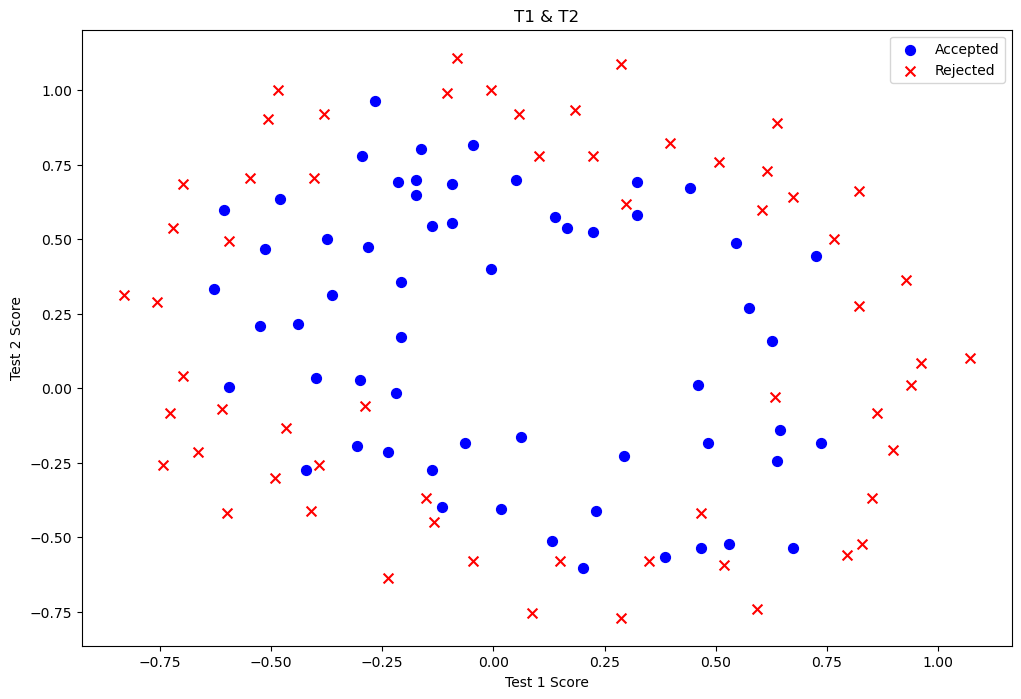

In [194]:
positive = df[df['Accepted'].isin([1])]
negative = df[df['Accepted'].isin([0])]

fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(positive['Test 1'], positive['Test 2'], s=50, c='b', marker='o', label='Accepted')
ax.scatter(negative['Test 1'], negative['Test 2'], s=50, c='r', marker='x', label='Rejected')
ax.legend()
ax.set_xlabel('Test 1 Score')
ax.set_ylabel('Test 2 Score')

plt.title("T1 & T2")
plt.show()

## Feature mapping 特征映射

根据图表显示没有线性决策界限来分开两类数据。

解决方法
- 使用逻辑回归这样的线性技术来从原始特征的多项式中得到的特征。
- 为每组数据创造更多的特征，所以我们为每组$x_1,x_2$添加了最高到`degree`次幂的特征

```
for i in 0...degree

    for j in 0...i

        output x^i - j * y^j
```

$$
mapFeature(x) =
\begin{pmatrix}
x_1 \\ x_2
\end{pmatrix} \rightarrow \begin{pmatrix}
1 \\ x_1 \\ x_2\\ x_1^2 \\ x_1x_2 \\ x_2^2 \\ \cdot  \\ \cdot  \\ \cdot  \\ x_1x_2^{degree - 1}\\x_2^{degree}
\end{pmatrix} $$

In [195]:
def feature_mapping(x, y, power, as_ndarray=False):
    data = {'F{}{}'.format(i-j, j): np.power(x, i-j) * np.power(y, j)
            for i in range(0, power+1)
            for j in range(0, i+1)
       }

    if as_ndarray:
        return pd.DataFrame(data).values
    else:
        return pd.DataFrame(data)

In [196]:
# init x1, x2, y

## 如果命名的时候没有空格可以使用.连接
# x1 = df.Tets_1.values
# x2 = df.Test_2.values

x1 = df['Test 1'].values
x2 = df['Test 2'].values

y = df.Accepted.values

In [197]:
data = feature_mapping(x1, x2, power=6)

data.head()

,F00,F10,F01,F20,F11,F02,F30,F21,F12,F03,...,F23,F14,F05,F60,F51,F42,F33,F24,F15,F06
0,1.0,0.051267,0.69956,0.002628,0.035864,0.489384,0.000135,0.001839,0.025089,0.342354,...,0.000900,0.012278,0.167542,1.815630e-08,2.477505e-07,0.000003,0.000046,0.000629,0.008589,0.117206
1,1.0,-0.092742,0.68494,0.008601,-0.063523,0.469143,-0.000798,0.005891,-0.043509,0.321335,...,0.002764,-0.020412,0.150752,6.362953e-07,-4.699318e-06,0.000035,-0.000256,0.001893,-0.013981,0.103256
2,1.0,-0.213710,0.69225,0.045672,-0.147941,0.479210,-0.009761,0.031616,-0.102412,0.331733,...,0.015151,-0.049077,0.158970,9.526844e-05,-3.085938e-04,0.001000,-0.003238,0.010488,-0.033973,0.110047
3,1.0,-0.375000,0.50219,0.140625,-0.188321,0.252195,-0.052734,0.070620,-0.094573,0.126650,...,0.017810,-0.023851,0.031940,2.780914e-03,-3.724126e-03,0.004987,-0.006679,0.008944,-0.011978,0.016040
4,1.0,-0.513250,0.46564,0.263426,-0.238990,0.216821,-0.135203,0.122661,-0.111283,0.100960,...,0.026596,-0.024128,0.021890,1.827990e-02,-1.658422e-02,0.015046,-0.013650,0.012384,-0.011235,0.010193


In [198]:
data.describe()

,F00,F10,F01,F20,F11,F02,F30,F21,F12,F03,...,F23,F14,F05,F60,F51,F42,F33,F24,F15,F06
count,118.0,118.000000,118.000000,118.000000,118.000000,118.000000,1.180000e+02,118.000000,118.000000,118.000000,...,118.000000,1.180000e+02,118.000000,1.180000e+02,118.000000,1.180000e+02,118.000000,1.180000e+02,118.000000,1.180000e+02
mean,1.0,0.054779,0.183102,0.247575,-0.025472,0.301370,5.983333e-02,0.030682,0.015483,0.142350,...,0.018278,4.089084e-03,0.115710,7.837118e-02,-0.000703,1.893340e-02,-0.001705,2.259170e-02,-0.006302,1.257256e-01
std,0.0,0.496654,0.519743,0.248532,0.224075,0.284536,2.746459e-01,0.134706,0.150143,0.326134,...,0.058513,9.993907e-02,0.299092,1.938621e-01,0.058271,3.430092e-02,0.037443,4.346935e-02,0.090621,2.964416e-01
min,1.0,-0.830070,-0.769740,0.000040,-0.484096,0.000026,-5.719317e-01,-0.358121,-0.483743,-0.456071,...,-0.142660,-4.830370e-01,-0.270222,6.472253e-14,-0.203971,2.577297e-10,-0.113448,2.418097e-10,-0.482684,1.795116e-14
25%,1.0,-0.372120,-0.254385,0.043243,-0.178209,0.061086,-5.155632e-02,-0.023672,-0.042980,-0.016492,...,-0.001400,-7.449462e-03,-0.001072,8.086369e-05,-0.006381,1.258285e-04,-0.005749,3.528590e-04,-0.016662,2.298277e-04
50%,1.0,-0.006336,0.213455,0.165397,-0.016521,0.252195,-2.544062e-07,0.006603,-0.000039,0.009734,...,0.001026,-8.972096e-09,0.000444,4.527344e-03,-0.000004,3.387050e-03,-0.000005,3.921378e-03,-0.000020,1.604015e-02
75%,1.0,0.478970,0.646563,0.389925,0.100795,0.464189,1.099616e-01,0.086392,0.079510,0.270310,...,0.021148,2.751341e-02,0.113020,5.932959e-02,0.002104,2.090875e-02,0.001024,2.103622e-02,0.001289,1.001215e-01
max,1.0,1.070900,1.108900,1.146827,0.568307,1.229659,1.228137e+00,0.449251,0.505577,1.363569,...,0.287323,4.012965e-01,1.676725,1.508320e+00,0.250577,2.018260e-01,0.183548,2.556084e-01,0.436209,1.859321e+00


## Regularized cost Function

$$J\left( \theta  \right)=\frac{1}{m}\sum\limits_{i=1}^{m}{[-{{y}^{(i)}}\log \left( {{h}_{\theta }}\left( {{x}^{(i)}} \right) \right)-\left( 1-{{y}^{(i)}} \right)\log \left( 1-{{h}_{\theta }}\left( {{x}^{(i)}} \right) \right)]}+\frac{\lambda }{2m}\sum\limits_{j=1}^{n}{\theta _{j}^{2}}$$

### 初始化数据

In [199]:
# init X, y and theta
theta = np.zeros(data.shape[1])
X = feature_mapping(x1, x2, power=6, as_ndarray=True)

In [200]:
X.shape, y.shape, theta.shape

((118, 28), (118,), (28,))

In [201]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def cost(theta, X, y):
    h = sigmoid(X @ theta)

    cost_positive = -y * np.log(h)
    cost_negative = (1 - y) * np.log(1 - h)

    return np.mean(cost_positive) - np.mean(cost_negative)

def gradient(theta, X, y):
    return X.T @ (sigmoid(X @ theta) - y) / len(X)

### 正则化Cost

$$  h_{\theta}(x) = \frac{1}{1 + e^{-\theta^Tx}}  $$


$$ \theta^Tx = \theta_1 + \theta_2x_1 + \theta_3x_2 + \theta_4x_1^2 + \theta_5x_1x_2 + \theta_6x_2^2 + ... + \theta_{28}x_2^6 $$

$\theta_1$作为一个偏置项，一般不会参与正则化计算，目标$|\theta_i|(i \ge 2)尽可能小$

In [202]:
def cost_regularized(theta, X, y, lambda_ = 1):
    """
    正则化逻辑回归代价函数

    参数:
    theta : (n + 1,) 参数向量
    X     : (m,n) 特征矩阵
    y     : (m,) 标签向量
    lambda_ : 正则化系数

    返回:
    cost : 标量代价值
    """
    # 正则化项（排除截距theta[0])
    reg_term = (lambda_ / (2 * len(X))) * np.power(theta[1:], 2).sum()
    # 总代价 = 平均损失 + 正则化项
    return cost(theta, X, y) + reg_term

In [203]:
cost_regularized(theta, X, y)

np.float64(0.6931471805599454)

### 正则化梯度

原始正则化梯度公式为：
$$\frac{\partial J\left( \theta  \right)}{\partial {{\theta }_{j}}}=\left ( \frac{1}{m}\sum\limits_{i=1}^{m}{({{h}_{\theta }}\left( {{x}^{(i)}} \right)-{{y}^{(i)}})x_{_{j}}^{(i)}} \right )  + \frac{\lambda}{m}\theta_j \ for\ j \ge 1$$

这个梯度由两部分组成：

   - 原始梯度：来自损失函数

   - 正则化梯度项：来自L2正则化项$\frac{\lambda }{2m}\sum\limits_{j=1}^{n}{\theta _{j}^{2}}$的导数


#### 梯度下降的更新规则

如果我们要使用梯度下降法令这个代价函数最小化，因为我们未对${{\theta }_{0}}$ 进行正则化，所以梯度下降算法将分两种情形：
\begin{align}
  & Repeat\text{ }until\text{ }convergence\text{ }\!\!\{\!\!\text{ } \\
 & \text{     }{{\theta }_{0}}:={{\theta }_{0}}-a\frac{1}{m}\sum\limits_{i=1}^{m}{[{{h}_{\theta }}\left( {{x}^{(i)}} \right)-{{y}^{(i)}}]x_{_{0}}^{(i)}} \\
 & \text{     }{{\theta }_{j}}:={{\theta }_{j}}-a\frac{1}{m}\sum\limits_{i=1}^{m}{[{{h}_{\theta }}\left( {{x}^{(i)}} \right)-{{y}^{(i)}}]x_{j}^{(i)}}+\frac{\lambda }{m}{{\theta }_{j}} \\
 & \text{          }\!\!\}\!\!\text{ } \\
 & Repeat \\
\end{align}

对上面的算法中 j=1,2,...,n 时的更新式子进行调整可得：
${{\theta }_{j}}:={{\theta }_{j}}(1-a\frac{\lambda }{m})-a\frac{1}{m}\sum\limits_{i=1}^{m}{({{h}_{\theta }}\left( {{x}^{(i)}} \right)-{{y}^{(i)}})x_{j}^{(i)}}$


**调整后的更新公式**

\begin{align}
\theta_j
&:= \theta_j - \alpha \left[ \frac{1}{m} \sum_{i=1}^m (h_\theta(x^{(i)}) - y^{(i)}) x_j^{(i)} + \frac{\lambda}{m} \theta_j \right] \\
&:= \theta_j - \alpha \cdot \frac{1}{m} \sum_{i=1}^m (h_\theta(x^{(i)}) - y^{(i)}) x_j^{(i)} - \alpha \cdot \frac{\lambda}{m} \theta_j \quad \text{(展开项)} \\
&:= \theta_j \left( 1 - \alpha \frac{\lambda}{m} \right) - \alpha \cdot \frac{1}{m} \sum_{i=1}^m (h_\theta(x^{(i)}) - y^{(i)}) x_j^{(i)} \quad \text{(合并参数项)}
\end{align}

In [204]:
def gradient_regularized(theta, X, y, lambda_ = 1):
    reg_theta = lambda_ * theta[1:] / len(X)
    term = np.concatenate([np.array([0]), reg_theta])
    return gradient(theta, X, y) + term

In [205]:
gradient(theta, X, y)

array([8.47457627e-03, 1.87880932e-02, 7.77711864e-05, 5.03446395e-02,
       1.15013308e-02, 3.76648474e-02, 1.83559872e-02, 7.32393391e-03,
       8.19244468e-03, 2.34764889e-02, 3.93486234e-02, 2.23923907e-03,
       1.28600503e-02, 3.09593720e-03, 3.93028171e-02, 1.99707467e-02,
       4.32983232e-03, 3.38643902e-03, 5.83822078e-03, 4.47629067e-03,
       3.10079849e-02, 3.10312442e-02, 1.09740238e-03, 6.31570797e-03,
       4.08503006e-04, 7.26504316e-03, 1.37646175e-03, 3.87936363e-02])

In [206]:
gradient_regularized(theta, X, y)

array([8.47457627e-03, 1.87880932e-02, 7.77711864e-05, 5.03446395e-02,
       1.15013308e-02, 3.76648474e-02, 1.83559872e-02, 7.32393391e-03,
       8.19244468e-03, 2.34764889e-02, 3.93486234e-02, 2.23923907e-03,
       1.28600503e-02, 3.09593720e-03, 3.93028171e-02, 1.99707467e-02,
       4.32983232e-03, 3.38643902e-03, 5.83822078e-03, 4.47629067e-03,
       3.10079849e-02, 3.10312442e-02, 1.09740238e-03, 6.31570797e-03,
       4.08503006e-04, 7.26504316e-03, 1.37646175e-03, 3.87936363e-02])

## 拟合参数

In [207]:
import scipy.optimize as opt
res = opt.minimize(fun=cost_regularized, x0=theta, jac=gradient_regularized,method='Newton-CG', args=(X, y))

In [208]:
res

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 0.5290027297127673
       x: [ 1.273e+00  6.253e-01 ... -1.439e-01 -9.247e-01]
     nit: 6
     jac: [-4.249e-08  1.057e-07 ... -3.795e-09  2.911e-09]
    nfev: 7
    njev: 59
    nhev: 0

## 预测分析

In [209]:
def predict(theta, X):
    prob = sigmoid(X @ theta)
    return (prob >= 0.5).astype(int)

In [210]:
from sklearn.metrics import classification_report
y_pred = predict(res.x, X)
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.75      0.82        60
           1       0.78      0.91      0.84        58

    accuracy                           0.83       118
   macro avg       0.84      0.83      0.83       118
weighted avg       0.84      0.83      0.83       118



## 决策边界

In [211]:
# 得到theta
def find_theta(power, l):
    '''
    power: int
        raise x1, x2 to polynomial power
    l: int
        lambda constant for regularization term
    '''
    file_path = 'ex2data2.txt'
    dataframe = pd.read_csv(path, header=None, names=['Test1', 'Test2', 'Accepted'])
    dataframe.head()

    y_ = dataframe.Accepted
    x1_ = dataframe['Test1'].values
    x2_ = dataframe['Test2'].values
    X_ = feature_mapping(x1_, x2_, power, as_ndarray=True)
    theta_ = np.zeros(X.shape[1])

    res_ = opt.minimize(fun=cost_regularized, x0=theta_, args=(X_, y_, l), method='TNC', jac=gradient_regularized)
    return res_.x

- 找到所有满足 $X * \theta = 0$ 的 x
- instead of solving polynomial equation, just create a coridate x,y grid that is dense enough, and find all those $X * \theta$ that is close enough to 0, then plot them

In [212]:
# 决策边界，thetaX = 0, thetaX <= threshold
def find_decision_boundary(density, power, theta, threshold):
    t1 = np.linspace(-1, 1.2, density)
    t2 = np.linspace(-1, 1.2, density)
    cordinates = [(i, j) for i in t1 for j in t2]
    x_cord, y_cord = zip(*cordinates)
    mapped_cord = feature_mapping(x_cord, y_cord, power)

    pred = mapped_cord.values @ theta.T
    decision = mapped_cord[np.abs(pred) <= threshold]

    return decision.F10, decision.F01

In [213]:
# 画决策边界
def draw_boundary(power, l):
    density = 1000
    threshold = 2 * 10**-3

    theta_ = find_theta(power, l)
    x_, y_ = find_decision_boundary(density, power, theta_, threshold)
    positive_ = df[df['Accepted'].isin([1])]
    negative_ = df[df['Accepted'].isin([0])]

    fig, ax = plt.subplots(figsize=(12, 8))
    ax.scatter(positive_['Test 1'], positive_['Test 2'], s=50, c='b', marker='o', label='Accepted')
    ax.scatter(negative_['Test 1'], negative_['Test 2'], s=50, c='g', marker='x', label='Rejected')
    ax.scatter(x_, y_, s=50, c='r', marker='.', label='Decision Boundary')
    ax.legend()
    ax.set_xlabel('Test1 Score')
    ax.set_ylabel('Test2 Score')

    plt.show()

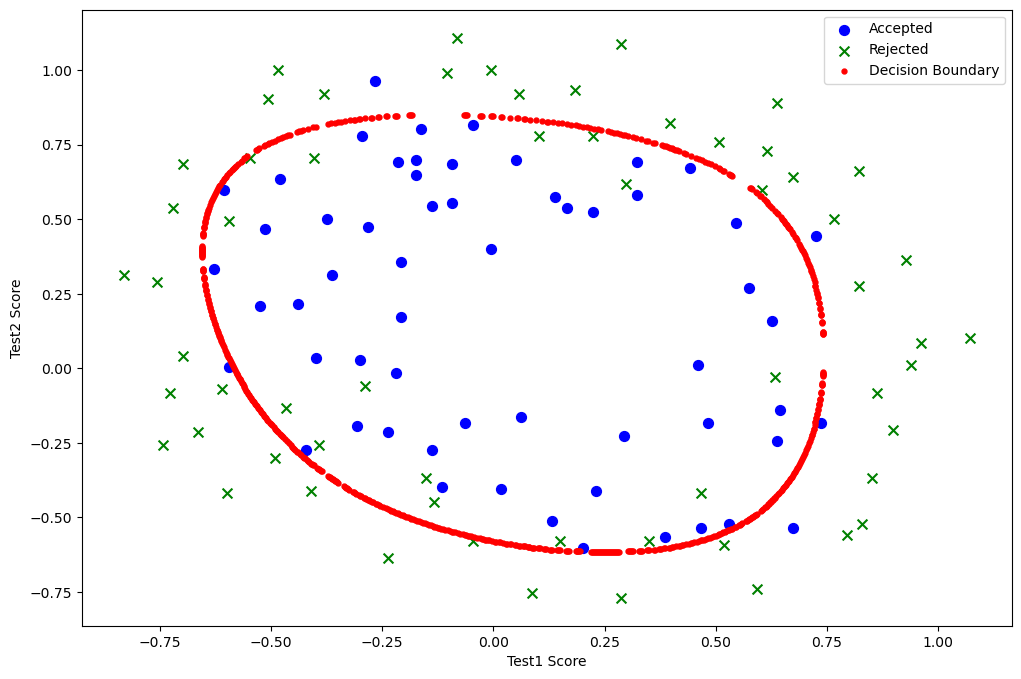

In [214]:
draw_boundary(6, l=1)

### overfitting 过拟合

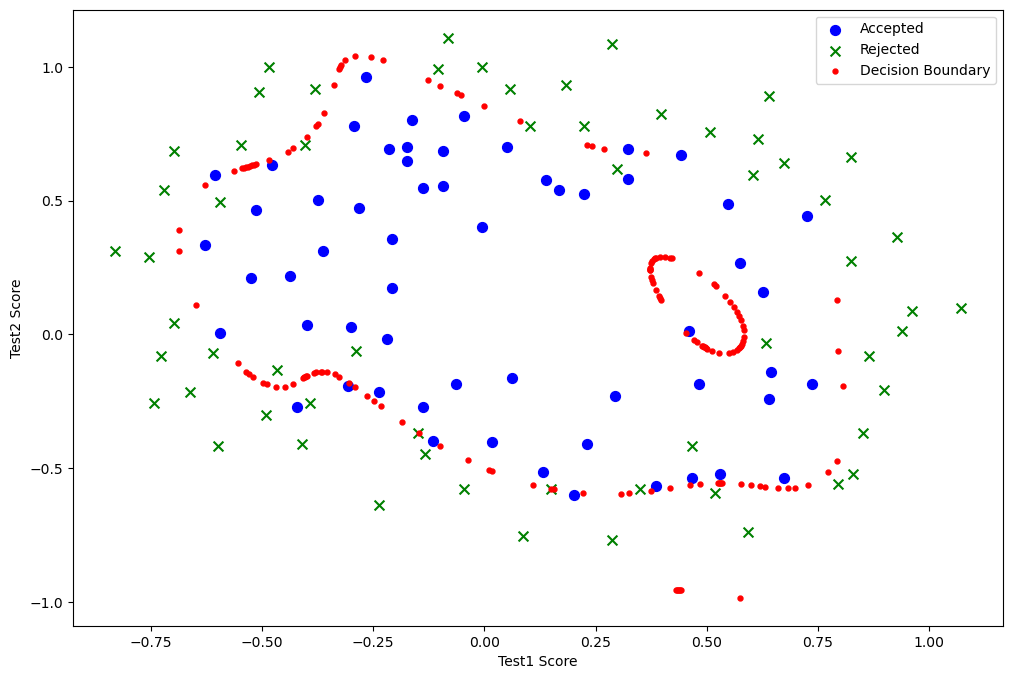

In [215]:
draw_boundary(6, l=0)

### underfitting 欠拟合

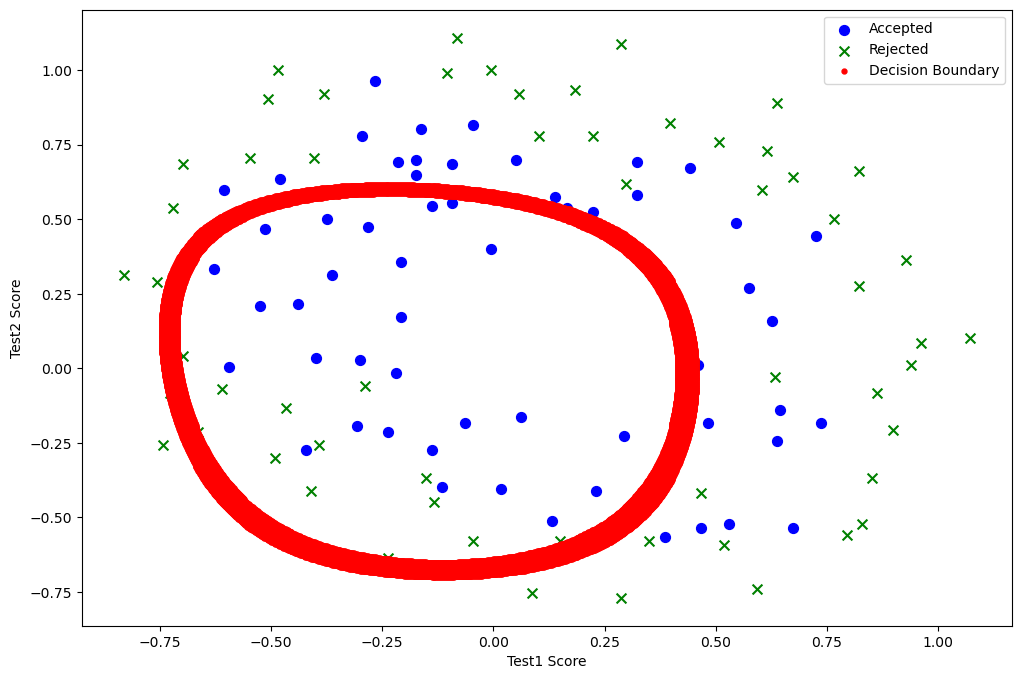

In [216]:
draw_boundary(6, l=100)